In [64]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_834299/388590871.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [66]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

# Substrategies

We've already identified some substrategies in the way the suggestion bar is used. In this section we examine how common these sub-strategies are and for which words they are used.

### Data prep

In [67]:
words = pd.read_csv('./data/words.csv')

In [68]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [69]:
participants = pd.read_csv('./data/participants_processed.csv', index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

### What is the prevalence of the sub-strategies?

#### What is the prevalence over all words?

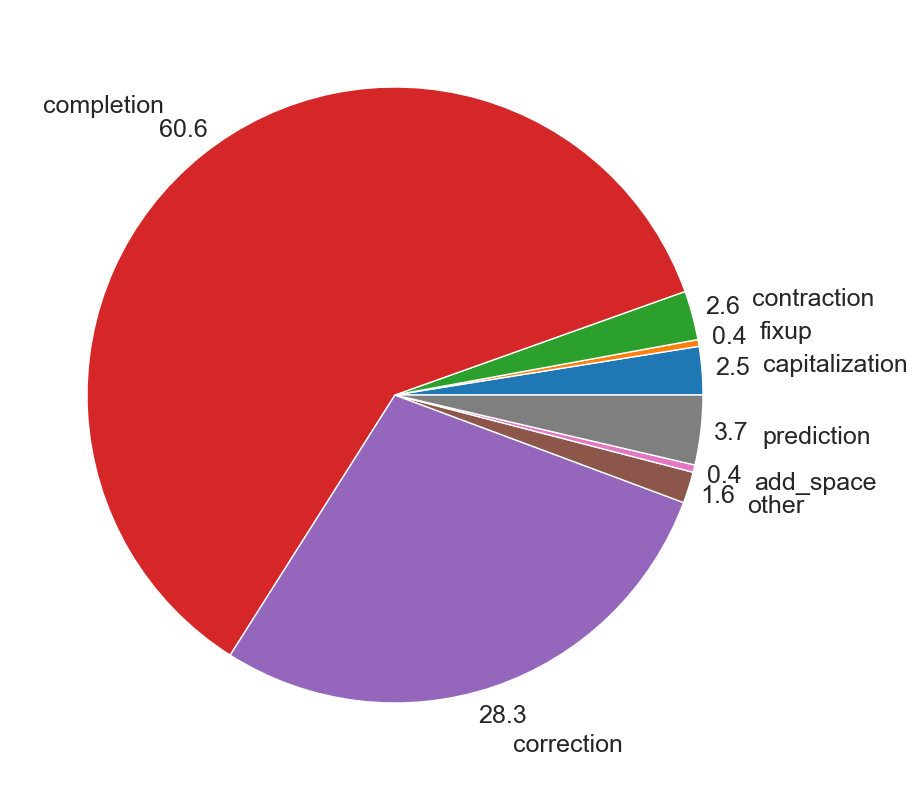

In [70]:
f,ax = plt.subplots(1, 1, figsize=(12,8))

data = words.loc[~words.ite2.isin(['no_change', 'none'])]
data.ite2.value_counts(normalize=True).sample(frac=1, random_state=4).plot.pie(autopct='%.1f', labeldistance=1.2, pctdistance=1.1, fontsize=18, radius=1, ax=ax)
ax.set_aspect('equal')
ax.set_ylabel('')
f.tight_layout()
f.savefig('./figures/pie_substrategies.png', dpi=300)

#### How does the prevalence change for capital and contraction words?

In [71]:
words.groupby('type').ite2.value_counts(normalize=True)

type         ite2          
contraction  contraction       0.488012
             completion        0.386440
             correction        0.101573
             other             0.011859
             prediction        0.005414
             capitalization    0.003609
             fixup             0.002578
             no_change         0.000258
             add_space         0.000258
generic      completion        0.629039
             correction        0.300760
             prediction        0.041555
             other             0.016459
             add_space         0.004489
             fixup             0.003687
             capitalization    0.002561
             no_change         0.001033
             contraction       0.000416
proper       completion        0.507532
             capitalization    0.236396
             correction        0.219976
             other             0.018456
             prediction        0.008007
             contraction       0.005021
            

#### What is the prevalence of select-and-modify strategies?

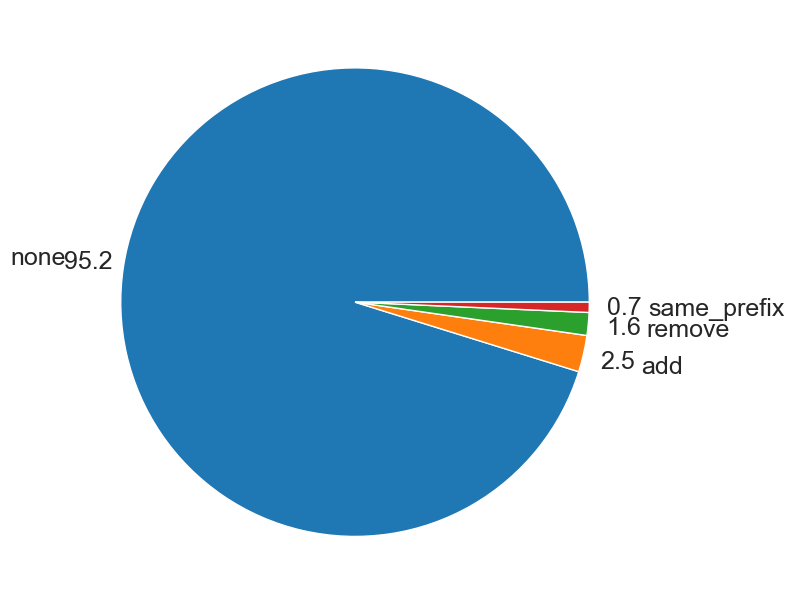

In [72]:
f,ax = plt.subplots(1, 1, figsize=(8,8))

data = words.loc[words.ite == 'predict'].copy()
# For our purposes, "other"-type strategic entries are treated as "none"
data.loc[data.strategic == 'other', 'strategic'] = 'none'
data.strategic.value_counts(normalize=True).plot.pie(autopct='%.1f', labeldistance=1.25, pctdistance=1.15, fontsize=18, radius=1, ax=ax)

ax.set_aspect('equal')
ax.set_ylabel('')
f.tight_layout()

f.savefig('./figures/pie_strategic.png', dpi=300)

In [73]:
words.loc[words.strategic != 'none'].strategic.value_counts(normalize=True)

strategic
add            0.377466
other          0.282163
remove         0.235201
same_prefix    0.105170
Name: proportion, dtype: float64

In [74]:
# Prevalnence not including "none"
words.strategic.value_counts(normalize=True).iloc[1:].sum()

0.06681520349105483

### What words are most commonly associated with a given strategy?

#### Data prep

In [75]:
data = words.copy()
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['none', 'completion', 'correction'])] # Focus on completion and correction
data = data.groupby('word').filter(lambda x: x.shape[0] > 20).groupby(['word']).ite2.value_counts(normalize=True) # Only include words that occured more than 20 times

#### What are the most common words for completion and correction?

In [76]:
data.unstack().sort_values('correction', ascending=False).head(20)

ite2,completion,correction,none
word,,,
center,NaN,0.700000,0.300000
labor,NaN,0.548387,0.451613
kilometres,0.125000,0.450000,0.425000
Azerbaijan,0.313953,0.441860,0.244186
humor,0.054545,0.290909,0.654545
Riviera,0.179487,0.256410,0.564103
labour,0.011111,0.211111,0.777778
centre,0.027523,0.211009,0.761468
organization,0.388889,0.208333,0.402778


In [77]:
data.unstack().sort_values('completion', ascending=False).head(20)

ite2,completion,correction,none
word,,,
inconvenience,0.518797,0.097744,0.383459
productivity,0.513333,0.046667,0.440000
unnecessary,0.462687,0.029851,0.507463
indefinitely,0.460938,0.062500,0.476562
demonstrations,0.443478,0.060870,0.495652
immediately,0.442308,0.076923,0.480769
absolutely,0.418440,0.035461,0.546099
measurements,0.416667,0.083333,0.500000
discrepancies,0.414062,0.070312,0.515625


### How is the probability of using a sub-strategy affected by: word length, word frequency, etc.

#### How does word length affect sub-strategy usage?

word_length  ite2          
1.0          none              0.997780
             other             0.001275
             add_space         0.000307
             prediction        0.000250
             completion        0.000205
             correction        0.000171
             no_change         0.000011
2.0          none              0.993093
             prediction        0.002501
             correction        0.002352
             completion        0.001522
             other             0.000368
             add_space         0.000082
             no_change         0.000033
             capitalization    0.000030
             contraction       0.000015
             fixup             0.000003
3.0          none              0.987097
             correction        0.005129
             completion        0.003642
             prediction        0.002241
             contraction       0.000814
             other             0.000610
             capitalization    0.000305
            

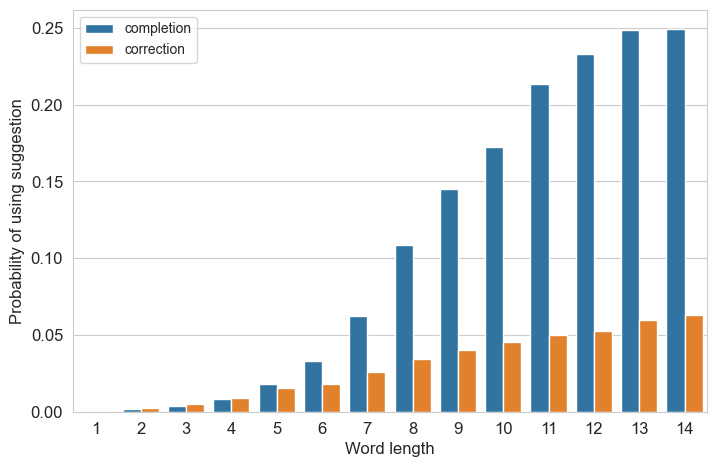

In [92]:
f,ax = plt.subplots(1, 1, figsize=(7, 4.5))

### Data prep ###
data = words.loc[words.word_length < 15].copy() 
data.ite2 = data.ite2.fillna('none')
# For each word length, get the relative prevalence of each substrategy
data = data.groupby('word_length').ite2.value_counts(normalize=True)
#print(data.to_string())
data = data.reset_index(name='probability')
# Focus on completion and correction
data = data.loc[data.ite2.isin(['completion', 'correction'])]

### Plot ###
data = data.sort_values('ite2') # Sort to get a consistent order
sns.barplot(x='word_length', y='probability', hue='ite2', data=data, ax=ax)

ax.set_xlabel('Word length')
ax.set_ylabel('Probability of using suggestion')
ax.set_xticklabels(range(1,15))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

f.tight_layout(pad = 0.1)
f.savefig('./figures/bar_word_length.png', dpi=300)

#### How does word frequency affect sub-strategy usage?

freq         ite2          
3924.81      none              0.669903
             completion        0.281553
             correction        0.048544
3926.40      none              0.966667
             correction        0.028205
             other             0.002564
             completion        0.002564
3950.13      none              0.828829
             completion        0.081081
             capitalization    0.054054
             correction        0.036036
3953.29      none              0.947712
             completion        0.026144
             correction        0.019608
             other             0.006536
3988.90      none              0.963801
             capitalization    0.022624
             completion        0.009050
             correction        0.004525
3992.85      none              0.802920
             completion        0.160584
             correction        0.036496
3996.02      none              1.000000
4034.78      none              0.960396
            

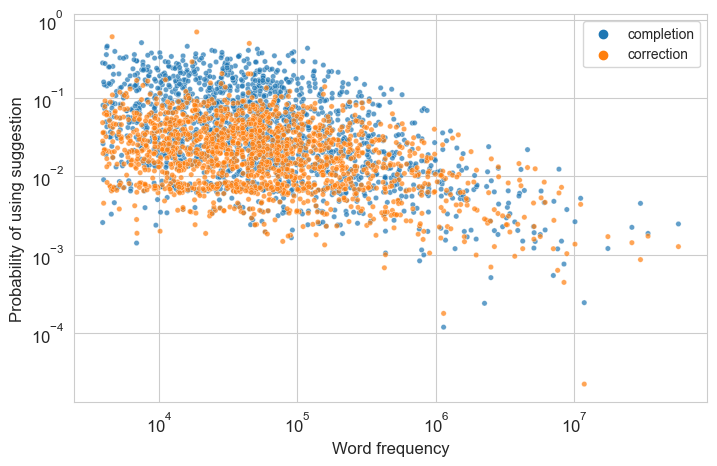

In [136]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

### Data prep ###
data = words.copy()
data.ite2 = data.ite2.fillna('none')
# Only include words with frequencies that appear more than 20 times in the dataset (for better probability estimation) 
data = data.groupby('freq').filter(lambda x: x.shape[0] > 20)
# For each frequency, get the relative prevalence of each substrategy
data = data.groupby(['freq']).ite2.value_counts(normalize=True)
print(data.to_string())
#print(data.head())
data = data.reset_index(name='probability')
#print(data.head())
#data = data.groupby('word_length').ite2.mean()
print(data.loc[data.freq < 100000, ["ite2", "probability"]].loc[data.ite2.isin(['completion', 'correction'])].head())
yo = data.loc[data.freq < 100000, ["ite2", "probability"]].loc[data.ite2.isin(['completion', 'correction'])]
print(yo.groupby("ite2").mean().head())
no = data.loc[data.freq > 100000, ["ite2", "probability"]].loc[data.ite2.isin(['completion', 'correction'])]
print(no.groupby("ite2").mean().head())
#print(data.to_string())
# Focus on completion and correction
data = data.loc[data.ite2.isin(['completion', 'correction'])]

### Plot ###
data = data.sort_values('ite2')
ax.set_xscale('log')
ax.set_yscale('log')
sns.scatterplot(x='freq', y='probability', hue='ite2', data=data, s=15, alpha=0.7, ax=ax)

ax.set_xlabel('Word frequency')
ax.set_ylabel('Probability of using suggestion')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])

f.tight_layout(pad=0.1)

f.savefig('./figures/scatter_word_frequency.png', dpi=300)

#### What does leadup speed tell us about sub-strategy usage?

ite2
completion    3.456949
correction    4.627513
none          5.834144
Name: speed, dtype: float64
ite2
completion    1.696906
correction    2.043726
none          2.128531
Name: speed, dtype: float64


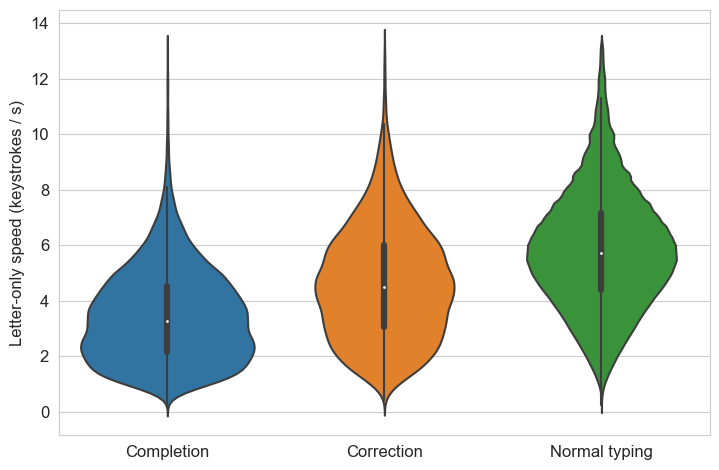

In [145]:
f,ax = plt.subplots(1, 1, figsize=(7, 4.5))

### Data prep ###
data = words.loc[(words.word_length > 2) & (words.word_length < 15)].copy()
data.ite2 = data.ite2.fillna('none')
# Focus on completion, correction, and normal typing
data = data.loc[data.ite2.isin(['none', 'completion', 'correction'])]
# Remove outliers (words typed extremely quickly)
data = data.loc[data.iki_letters > 75]
# Convert iki to speed
data['speed'] = data.iki_letters.apply(np.reciprocal) * 1000

print(data.groupby("ite2").speed.mean())
print(data.groupby("ite2").speed.std())

### Plot ###
data = data.sort_values('ite2')
sns.violinplot(x='ite2', y='speed', data=data, ax=ax)

ax.set_xticklabels(['Completion', 'Correction', 'Normal typing'])
ax.set_xlabel('')
ax.set_ylabel('Letter-only speed (keystrokes / s)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad=0)

f.savefig('./figures/violin_speed.png', dpi=300)

In [146]:
stats.f_oneway(data.loc[data.ite2 == 'none'].speed, data.loc[data.ite2 == 'completion'].speed, data.loc[data.ite2 == 'correction'].speed)

F_onewayResult(statistic=29130.686357935923, pvalue=0.0)

In [81]:
stats.ttest_ind(data.loc[data.ite2 == 'none'].speed, data.loc[data.ite2 == 'completion'].speed)

Ttest_indResult(statistic=229.0098813092218, pvalue=0.0)

In [82]:
stats.ttest_ind(data.loc[data.ite2 == 'none'].speed, data.loc[data.ite2 == 'correction'].speed)

Ttest_indResult(statistic=80.72692640550689, pvalue=0.0)

In [83]:
stats.ttest_ind(data.loc[data.ite2 == 'completion'].speed, data.loc[data.ite2 == 'correction'].speed)

Ttest_indResult(statistic=-76.02550546844874, pvalue=0.0)

### What are the relative importances of word length, word frequency, etc.?

#### Data prep

In [142]:
mask = words.ite.isin(['none', 'predict']) # Ignore autocorrected words
mask &= (words.word == words.ite_input) | (words.ite == 'none') # Only include words whose ite_input is the same as the final word (to avoid accidental suggestion usage)
mask &= words.word_length > 1 # Cannot detect suggestion for one-letter words
mask &= words.word_length < 14 # Not enough data for very long words
mask &= words.iki_letters > 30 # Remove outlier words that were typed extremely quickly
data = words.loc[mask, ['word', 'word_length', 'freq', 'iki_letters', 'ite2']].copy() # Focus on word length, word frequency, and leadup speed

# Convert iki to leadup speed
data['leadup_speed'] = data.iki_letters.apply(np.reciprocal) * 1000
data.drop('iki_letters', axis=1, inplace=True)

# Focus on correction and completion
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['none', 'correction', 'completion'])]

data.set_index('word', inplace=True)
data = data.dropna()

# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Preprocess y
y = data['ite2'].copy()

#### Logistic regression

In [143]:
# Helper to add asterix based on p-value
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

params = []
params_disp = []
X = sm.add_constant(X)

# For each sub-strategy
for i in y.sort_values().unique():
    if i == 'none':
        continue # Remove this to also calculate the probability of typing normally
        model = sm.Logit((y != i).astype(float), X)
    # Logistic regression
    model = sm.Logit((y == i).astype(float), X)
    results = model.fit(method='lbfgs', maxiter=1000)
    
    # Prepare a nice table of coefficients (add asterix, stderr, etc.)
    a = results.params
    for param,val in results.params.iteritems():
        a.loc[param] = '{}{}\n({})'.format(
            str(round(val, 2)),
            to_asterix(results.pvalues.loc[param]),
            str(round(results.bse.loc[param], 2))
        )
    params.append(results.params.to_frame(i)) # This is the parameters as numbers (without formatting)
    params_disp.append(a.to_frame(i)) # This is the parameters with asterux, etc.

# Create overall dataframe of parameters
params = pd.concat(params, axis=1, sort=False)
params_disp = pd.concat(params_disp, axis=1, sort=False)
params_disp = params_disp.fillna('N/A')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.75509D-01

At iterate    1    f=  3.35362D-01    |proj g|=  2.46225D-01


 This problem is unconstrained.



At iterate    2    f=  1.63178D-01    |proj g|=  8.95316D-02

At iterate    3    f=  1.17799D-01    |proj g|=  4.49954D-02

At iterate    4    f=  9.59899D-02    |proj g|=  1.79421D-02

At iterate    5    f=  8.62973D-02    |proj g|=  1.67291D-02

At iterate    6    f=  8.02412D-02    |proj g|=  4.53827D-03

At iterate    7    f=  7.87908D-02    |proj g|=  3.80338D-03

At iterate    8    f=  7.80581D-02    |proj g|=  3.54326D-03

At iterate    9    f=  7.75672D-02    |proj g|=  4.56240D-04

At iterate   10    f=  7.75424D-02    |proj g|=  4.44367D-04

At iterate   11    f=  7.75032D-02    |proj g|=  3.83050D-04

At iterate   12    f=  7.74907D-02    |proj g|=  2.27548D-04

At iterate   13    f=  7.74885D-02    |proj g|=  4.55764D-05

At iterate   14    f=  7.74884D-02    |proj g|=  3.65757D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

AttributeError: 'Series' object has no attribute 'iteritems'

In [ ]:
from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(params_disp.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


### What edit distance is associated with each completion vs. correction

#### Data prep

In [137]:
mask = (words.ite_input == words.word)
mask &= (words.ite_lev_dist <= words.ite_input_len) # Remove outlier extremely large levenshtein distances
mask &= words.word_length > 1 # Cannot detect sugggestion on one-letter words
mask &= words.word_length < 13 # Remove long words (no enough data)
mask &= words.ite_lev_dist > 0 # Ignore 0-LD changes

# Matrix for completion
data = words.loc[(words.ite2 == 'completion') & mask]
section1 = data.word_length
section2 = data.ite_lev_dist
matrix1 = data.groupby([section1, section2]).size().unstack().fillna(0)
matrix1 = matrix1.div(matrix1.sum(axis=1), axis=0) # Normalize rows

# Matrix for correction
data = words.loc[(words.ite2 == 'correction') & mask]
section1 = data.word_length
section2 = data.ite_lev_dist
matrix2 = data.groupby([section1,section2]).size().unstack().fillna(0)
matrix2 = matrix2.div(matrix2.sum(axis=1), axis=0) # Normalize rows

#### Heatmaps

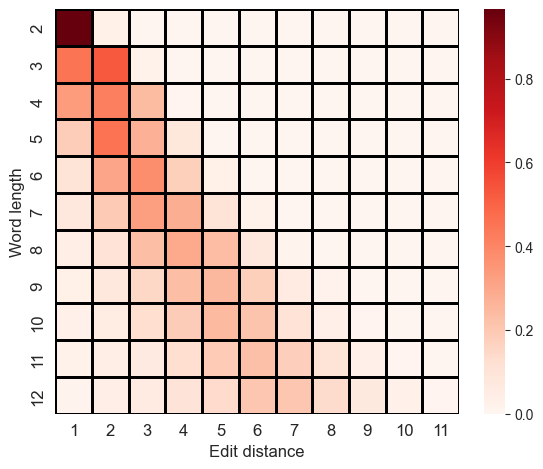

In [138]:
f,ax = plt.subplots(1, 1, figsize=(5.5, 4.5))

sns.heatmap(matrix1, ax=ax, cmap='Reds', linewidths=1, linecolor='k')

ax.set_yticklabels(range(2,13))
ax.set_xticklabels(range(1,12))
ax.set_ylabel('Word length')
ax.set_xlabel('Edit distance')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad=0)

f.savefig('./figures/heatmap_completion.png', dpi=300)

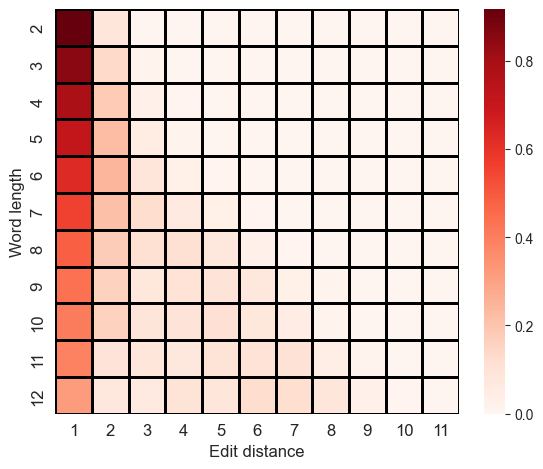

In [139]:
f,ax = plt.subplots(1, 1, figsize=(5.5, 4.5))

sns.heatmap(matrix2, ax=ax, cmap='Reds', linewidths=1, linecolor='k')

ax.set_yticklabels(range(2, 13))
ax.set_xticklabels(range(1, 12))
ax.set_ylabel('Word length')
ax.set_xlabel('Edit distance')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad=0)

f.savefig('./figures/heatmap_correction.png', dpi=300)

In [140]:
words.loc[(words.ite2 == 'completion') & mask & (words.word_length == 10)].ite_lev_dist.median()

5.0

In [141]:
words.loc[(words.ite2 == 'correction') & mask & (words.word_length == 10)].ite_lev_dist.median()

2.0